本章では，Bo Pang氏とLillian Lee氏が公開しているMovie Review Dataのsentence polarity dataset v1.0を用い，文を肯定的（ポジティブ）もしくは否定的（ネガティブ）に分類するタスク（極性分析）に取り組む．

70. データの入手・整形
文に関する極性分析の正解データを用い，以下の要領で正解データ（sentiment.txt）を作成せよ．

rt-polarity.posの各行の先頭に"+1 "という文字列を追加する（極性ラベル"+1"とスペースに続けて肯定的な文の内容が続く）
rt-polarity.negの各行の先頭に"-1 "という文字列を追加する（極性ラベル"-1"とスペースに続けて否定的な文の内容が続く）
上述1と2の内容を結合（concatenate）し，行をランダムに並び替える
sentiment.txtを作成したら，正例（肯定的な文）の数と負例（否定的な文）の数を確認せよ．

In [1]:
from pathlib import Path
data_path = Path('./data/08-ml/rt-polaritydata/rt-polaritydata/')

with open(data_path/'sentiment.txt', 'w') as w:
    pos_true_count = 0
    neg_true_count = 0
    with open(data_path/'rt-polarity.pos', encoding='latin_1') as r:
        
        for line in r:
            pos_true_count += 1
            s = '+1' + ' ' + line
            w.write(s)
            
    with open(data_path/'rt-polarity.neg', encoding='latin_1') as r:
        for line in r:
            neg_true_count += 1
            s = '-1' + ' ' + line
            w.write(s)
# count
with open(data_path/'sentiment.txt', 'r') as r:
    pos_count = 0
    neg_count = 0
    for line in r:
        if line.startswith('+1 '):
            pos_count += 1
        if line.startswith('-1 '):
            neg_count += 1
    print(f'postrue{pos_true_count}, pos{pos_count}\nnegtrue{neg_true_count}, neg{neg_count}')

postrue5331, pos5331
negtrue5331, neg5331


71. ストップワード
英語のストップワードのリスト（ストップリスト）を適当に作成せよ．さらに，引数に与えられた単語（文字列）がストップリストに含まれている場合は真，それ以外は偽を返す関数を実装せよ．さらに，その関数に対するテストを記述せよ．

In [2]:
from nltk.corpus import stopwords


stopWords = set(stopwords.words('english'))
def is_stop(word):
    return word in stopWords


72. 素性抽出
極性分析に有用そうな素性を各自で設計し，学習データから素性を抽出せよ．素性としては，レビューからストップワードを除去し，各単語をステミング処理したものが最低限のベースラインとなるであろう．

In [3]:
from gensim.corpora.wikicorpus import tokenize
from gensim import corpora
from nltk.stem.porter import PorterStemmer as PS
from scipy import sparse
import numpy as np


ps = PS()

def stemming(tokens):
    return list(map(ps.stem, tokens))

def line2feature_words(line):
    words = stemming(tokenize(line))
    wordsFiltered = [w for w in words if not is_stop(w)]
    return wordsFiltered


doc_count = 0
with open(data_path/'sentiment.txt', 'r') as r:
    with open(data_path/'feature_words.txt', 'w') as w:
        for line in r:
            doc_count += 1
            w.write(line[:3] + ' '.join(line2feature_words(line[3:])) + '\n')

# 辞書作成
def tokengen():
    with open(data_path/'feature_words.txt', 'r') as r:
        for line in r:
            yield line[3:].split(' ')
        
dictionary = corpora.Dictionary(tokengen())
dictionary.filter_extremes(no_below=5, no_above=0.5)

# 行列とラベル作成
labels = np.zeros(doc_count)
feature_matrix = sparse.lil_matrix((doc_count, len(dictionary)))
with open(data_path/'feature_words.txt', 'r') as r:
    for i, line in enumerate(r):
        if line.startswith('+1'):
            labels[i] = 1
        for wordid, num_occ in dictionary.doc2bow(line[3:].split(' ')):
            feature_matrix[i, wordid] = num_occ


/Users/ht/.pyenv/versions/miniconda3-latest/envs/nlp100/lib/python3.7/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


73. 学習
72で抽出した素性を用いて，ロジスティック回帰モデルを学習せよ．

In [4]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()
lr_model.fit(feature_matrix, labels)

/Users/ht/.pyenv/versions/miniconda3-latest/envs/nlp100/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

74. 予測
73で学習したロジスティック回帰モデルを用い，与えられた文の極性ラベル（正例なら"+1"，負例なら"-1"）と，その予測確率を計算するプログラムを実装せよ．

In [5]:
def predict(i):
    pred_prob = lr_model.predict_proba(feature_matrix[i:i+1])
    pred = lr_model.predict(feature_matrix[i:i+1])
    print(f'予測(0,1)={pred_prob[0]} 正解{labels[i]}')
    
for i in np.random.randint(0, doc_count, 10): 
    predict(i)

予測(0,1)=[0.82737543 0.17262457] 正解0.0
予測(0,1)=[0.97886336 0.02113664] 正解0.0
予測(0,1)=[0.00490048 0.99509952] 正解1.0
予測(0,1)=[0.37920753 0.62079247] 正解1.0
予測(0,1)=[0.74353984 0.25646016] 正解0.0
予測(0,1)=[0.99251453 0.00748547] 正解0.0
予測(0,1)=[0.9579197 0.0420803] 正解0.0
予測(0,1)=[0.48398503 0.51601497] 正解0.0
予測(0,1)=[0.97162599 0.02837401] 正解0.0
予測(0,1)=[0.85087382 0.14912618] 正解0.0


75. 素性の重み
73で学習したロジスティック回帰モデルの中で，重みの高い素性トップ10と，重みの低い素性トップ10を確認せよ．

In [6]:
weight = lr_model.coef_
print('高い10個')
for i in (-weight).argsort()[0][:10]:
    print(dictionary[i])
print('低い10個')
for i in weight.argsort()[0][:10]:
    print(dictionary[i])

高い10個
engross
unexpect
smarter
refresh
refreshingli
remark
resist

sli
examin
uniqu
低い10個
wast
bore
suppos
dull
fail
bore

appar
badli
flat
mindless


76. ラベル付け
学習データに対してロジスティック回帰モデルを適用し，正解のラベル，予測されたラベル，予測確率をタブ区切り形式で出力せよ．

In [9]:
pred_probs = lr_model.predict_proba(feature_matrix)
preds = lr_model.predict(feature_matrix)

with open(data_path/'model_pred', 'w') as w:
    for i in range(len(labels)):
        w.write(f'{labels[i]}\t{preds[i]}\t{pred_probs[i]}\n')
        

77. 正解率の計測
76の出力を受け取り，予測の正解率，正例に関する適合率，再現率，F1スコアを求めるプログラムを作成せよ．

In [12]:
def calc_score(path):
    #l = [tp, fp, fn, tp]
    l = [0, 0, 0, 0]
    with open(path) as f:
        for line in f:
            true = int(float(line.split('\t')[0]))
            pred = int(float(line.split('\t')[1]))
            l[(true<<1)+pred] += 1
    acc = (l[0]+l[3]) / (l[0]+l[1]+l[2]+l[3])
    precision = l[3] / (l[3]+l[1])
    recall = l[3] / (l[3]+l[2])
    f1 = 2 / ((1/precision)+(1/recall))
    print(f'acc:{acc}, prec:{precision},\n recall:{recall}, f:{f1}')
calc_score(data_path/'model_pred')

acc:0.8890452072781843, prec:0.8936977980258163,
 recall:0.8831363721628213, f:0.8883856967638457


78. 5分割交差検定
76-77の実験では，学習に用いた事例を評価にも用いたため，正当な評価とは言えない．すなわち，分類器が訓練事例を丸暗記する際の性能を評価しており，モデルの汎化性能を測定していない．そこで，5分割交差検定により，極性分類の正解率，適合率，再現率，F1スコアを求めよ．

In [18]:
data5 = []
labels5 = []
models5 = []
idx = np.arange(feature_matrix.shape[0])
for i in range(5):
    data5.append(feature_matrix[idx//100 % 5 == i])
    labels5.append(labels[idx//100 % 5 == i])
for i in range(5):
    train_data = np.concatenate([data5[j].toarray() for j in range(5) if j != i])
    train_label = np.concatenate([labels5[j] for j in range(5) if j != i])
    model = LogisticRegression()
    model.fit(train_data, train_label)
    models5.append(model)
    pred_probs = model.predict_proba(data5[i])
    preds = model.predict(data5[i])
    with open(data_path/f'model_pred{i}', 'w') as w:
        for k in range(len(labels5[i])):
            w.write(f'{labels5[i][k]}\t{preds[k]}\t{pred_probs[k]}\n')
    calc_score(data_path/f'model_pred{i}')
    


/Users/ht/.pyenv/versions/miniconda3-latest/envs/nlp100/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ht/.pyenv/versions/miniconda3-latest/envs/nlp100/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ht/.pyenv/versions/miniconda3-latest/envs/nlp100/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ht/.pyenv/versions/miniconda3-latest/envs/nlp100/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ht/.p

acc:0.7477272727272727, prec:0.752548656163114,
 recall:0.7381818181818182, f:0.7452960073428178
acc:0.7312673450508789, prec:0.739612188365651,
 recall:0.7281818181818182, f:0.7338524965643609
acc:0.7395238095238095, prec:0.755781683626272,
 recall:0.7427272727272727, f:0.7491976157725814
acc:0.7490476190476191, prec:0.7535211267605634,
 recall:0.7264791464597479, f:0.7397530864197531
acc:0.7390476190476191, prec:0.7220039292730844,
 recall:0.735, f:0.7284440039643212


79. 適合率-再現率グラフの描画
ロジスティック回帰モデルの分類の閾値を変化させることで，適合率-再現率グラフを描画せよ．

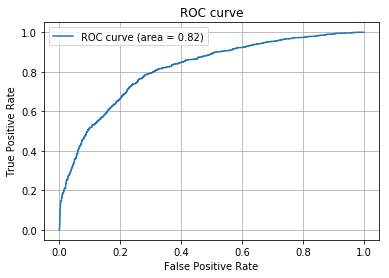

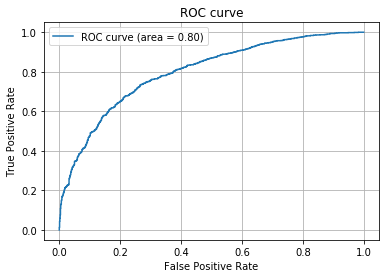

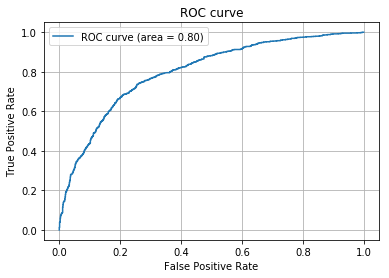

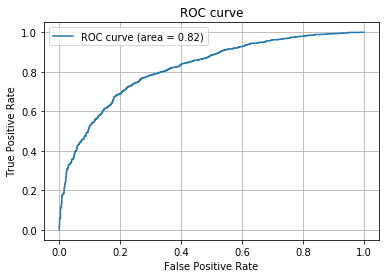

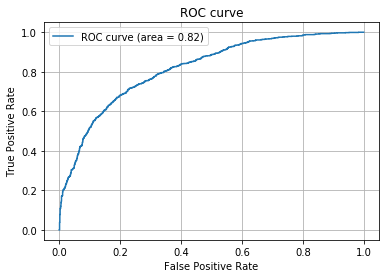

In [21]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

for i in range(5):
    train_data = np.concatenate([data5[j].toarray() for j in range(5) if j != i])
    train_label = np.concatenate([labels5[j] for j in range(5) if j != i])
    model = models5[i]
    pred_probs = model.predict_proba(data5[i])
    preds = model.predict(data5[i])
    # FPR, TPR(, しきい値) を算出
    fpr, tpr, thresholds = metrics.roc_curve(labels5[i], pred_probs[:,1])

    # ついでにAUCも
    auc = metrics.auc(fpr, tpr)

    # ROC曲線をプロット
    plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.savefig(data_path/f'roc{i}.png')
    plt.show()

